# The Battle of Neighborhoods

### Finally we get to Analyse the Toronto Data & New York Data

We will be using the Toronto Data Notebook and the New York Data Notebook - These Notebooks have been published to Github

Import Packages

In [3]:
# Basic Packages
import re # Package for handling Regular Expression related
import json # Package for handling JSON Files and objects
import requests # Package used to request for a partivular object on web

# Packges for Data Manipulation
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize # json_normalize is used to flatten json file to a tabular format

pd.set_option('display.max_columns', None) # Displays the entire columns

# Packages for Visualization
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns # Package for generating beautiful visualizations
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# Packages for getting geospatial coordinates
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from sklearn.cluster import KMeans

%matplotlib inline

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          91 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geopy-1.20.0         | 57 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executi

## Analysing the Toronto Data

In [4]:
toronto_df = pd.read_csv(r'Toronto Postal Codes.csv')
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


Geopy package, get the latitude and longitude of the location. The attribute user_agent is used in Nominatim method in order to remove the warning caused. The latitude and longitude returned is approximately correct.

In [5]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
toronto_latitude = location.latitude
toronto_longitude = location.longitude

print("The coordinates of Toronto: {}, {}".format(toronto_latitude, toronto_longitude))

The coordinates of Toronto: 43.653963, -79.387207


Using folium generate a map for better understanding of the distribution. 
In order to create the popup labels, iterate through the Latitude, Longitude, Borough, Neighborhood and use the Popup method of folium to generate the label.

In [6]:
map_toronto = folium.Map(location = [toronto_latitude, toronto_longitude], zoom_start = 10)

for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_toronto)
    
map_toronto

In [7]:
down_df = toronto_df[toronto_df['Borough'] == 'Downtown Toronto'].reset_index(drop = True)
down_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937
2,M5B,Downtown Toronto,Garden District,43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [8]:
down_df.shape[0]

36

There are about 36 Neighborhoods in Downtown Toronto

In [9]:
address = 'Downtown Toronto, ON'

geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
down_latitude = location.latitude
down_longitude = location.longitude

print('The coordinates of Downtown Toronto: {}, {}'.format(down_latitude, down_longitude))

The coordinates of Downtown Toronto: 43.6563221, -79.3809161


In [10]:
print('Getting the coordinates of Downtown Toronto: {}, {}'.format(down_latitude, down_longitude))

Getting the coordinates of Downtown Toronto: 43.6563221, -79.3809161


In [11]:
map_down = folium.Map(location = [down_latitude, down_longitude], zoom_start = 13)

for lat, lng, neighborhood, borough in zip(down_df['Latitude'], down_df['Longitude'], down_df['Neighborhood'], down_df['Borough']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_down)
    
map_down

In [13]:
down_neighbor_lat = down_df.loc[0, 'Latitude'] # get latitude of first entry
down_neighbor_lng = down_df.loc[0, 'Longitude'] #get longitude of first entry
down_neighbor_name = down_df.loc[0, 'Neighborhood']

print("Latitude: {}, \nLongitude: {}, \nNeighborhood Name: {}".format(down_neighbor_lat, 
                       down_neighbor_lng, 
                       down_neighbor_name))

Latitude: 43.6542599, 
Longitude: -79.3606359, 
Neighborhood Name: Harbourfront


*Please note that the ClientID and Client Secret will be removed*

Use the Foursquare API to get the loction data for the particular neighborhood.

We can now proceed to generate the url needed for data extraction. There is a URL convention that should be used in order to get the results

In [15]:
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    down_neighbor_lat, 
    down_neighbor_lng, 
    radius,
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=KOXYYD050SV30CYYMDVVGJGTR1ADE3TUYDKK1DCOATCHRM0A&client_secret=AZHP5Q40BJKP21ASHOXGC0SD0PZTZLR0NFK544WJ5YLCKMDY&v=20181204&ll=43.6542599,-79.3606359&radius=500&limit=100'

In [16]:
down_results = requests.get(url).json() # Get the data in JSON format
down_results

{'meta': {'code': 200, 'requestId': '5ddd948df7706a001b9ea3e7'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 49,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
 

Helper function to get the category types

In [17]:
def get_category_type(row):
    '''
    Helper code to get the category type
    '''
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Nearby Venue Neighborhoods

down_venues = down_results['response']['groups'][0]['items']
down_nearby = json_normalize(down_venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
down_nearby = down_nearby.loc[:, filtered_columns]
down_nearby['venue.categories'] = down_nearby.apply(get_category_type, axis = 1)
down_nearby.columns = [col.split(".")[-1] for col in down_nearby.columns]
down_nearby.head()

Helper function returns nearby venues for all the neighborhoods. It simply iterates for every neighborhood and generates the url from which the data is extracted and modified for our use

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    '''
    This helper function returns the nearby venues
    '''
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues_down = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues_down.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues_down)

In [20]:
down_venues = getNearbyVenues(names=down_df['Neighborhood'],
                                   latitudes=down_df['Latitude'],
                                   longitudes=down_df['Longitude']
                                  )

Harbourfront
Ryerson
Garden District
St. James Town
Berczy Park
Central Bay Street
Christie
Adelaide
King
Richmond
Harbourfront East
Toronto Islands
Union Station
Design Exchange
Toronto Dominion Centre
Commerce Court
Victoria Hotel
Harbord
University of Toronto
Chinatown
Grange Park
Kensington Market
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown
St. James Town
First Canadian Place
Underground city
Church and Wellesley


In [21]:
print(down_venues.shape)
down_venues.head()

(2428, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [22]:
down_venues.loc[-1] = ['St. James', 43.6709, -79.3733, "Al's Wine", 43.6709, -79.3733, "Bar"]

Onehot Encode the categories

In [23]:
down_onehot = pd.get_dummies(down_venues[['Venue Category']], prefix = '', prefix_sep = "")

down_onehot['Neighborhood'] = down_venues['Neighborhood']

fixed_columns = [down_onehot.columns[-1]] + list(down_onehot.columns[:-1])
down_onehot = down_onehot[fixed_columns]

down_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Harbourfront,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Harbourfront,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [24]:
down_grouped = down_onehot.groupby('Neighborhood').mean().reset_index()
down_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Adelaide,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.03,0.0,0.0,0.000000,0.0,0.03,0.0,0.000000,0.0,0.000000,0.030000,0.000000,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.01,0.000000,0.01,0.020000,0.0,0.0,0.0,0.03,0.01,0.000000,0.050000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.070000,0.0,0.0,0.0,0.01,0.000000,0.0,0.020000,0.0,0.03,0.000000,0.0,0.010000,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.0,0.020000,0.0,0.000000,0.01,0.0,0.000000,0.01,0.000000,0.010000,0.000000,0.02,0.01,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,0.01,0.010000,0.000000,0.010000,0.010000,0.010000,0.000000,0.01,0.0,0.0,0.01,0.0,0.000000,0.010000,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.0,0.01,0.0,0.01,0.01,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.020000,0.000000,0.010000,0.0,0.0,0.0,0.000000,0.01,0.01,0.030000,0.0,0.0,0.02,0.01,0.010000,0.0,0.000000,0.010000,0.0,0.010000,0.0,0.01,0.0,0.000000,0.0,0.0,0.01,0.00

In [25]:
down_grouped_neighbor = down_grouped['Neighborhood'] # Store the neighborhood column in a variable

Store all the column names that end with Restaurant as we are interested in this

In [27]:
down_grouped = down_grouped.loc[:, down_grouped.columns.str.endswith('Restaurant')]
down_grouped.head()

,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0.0,0.03,0.03,0.0,0.01,0.000000,0.000000,0.01,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.01,0.010000,0.0,0.010000,0.010000,0.010000,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.030000,0.010000,0.03,0.000000,0.040000,0.0,0.020000,0.0
1,0.0,0.00,0.00,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0
2,0.0,0.00,0.00,0.0,0.00,0.000000,0.000000,0.00,0.017544,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.017544,0.0,0.00,0.017544,0.0,0.000000,0.017544,0.017544,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.017544,0.035088,0.00,0.000000,0.017544,0.0,0.017544,0.0
3,0.0,0.00,0.00,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0
4,0.0,0.00,0.00,0.0,0.00,0.022727,0.045455,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.022727,0.045455,0.022727,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.045455,0.000000,0.00,0.022727,0.022727,0.0,0.000000,0.0


In [28]:
# Add the neighborhood column
down_grouped['Neighborhood'] = down_grouped_neighbor
down_grouped.head()

,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Neighborhood
0,0.0,0.03,0.03,0.0,0.01,0.000000,0.000000,0.01,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.01,0.010000,0.0,0.010000,0.010000,0.010000,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.030000,0.010000,0.03,0.000000,0.040000,0.0,0.020000,0.0,Adelaide
1,0.0,0.00,0.00,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,Bathurst Quay
2,0.0,0.00,0.00,0.0,0.00,0.000000,0.000000,0.00,0.017544,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.017544,0.0,0.00,0.017544,0.0,0.000000,0.017544,0.017544,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.017544,0.035088,0.00,0.000000,0.017544,0.0,0.017544,0.0,Berczy Park
3,0.0,0.00,0.00,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,CN Tower
4,0.0,0.00,0.00,0.0,0.00,0.022727,0.045455,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.022727,0.045455,0.022727,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.045455,0.000000,0.00,0.022727,0.022727,0.0,0.000000,0.0,Cabbagetown


In [30]:
# Rearrange the neighborhood column to first
cols = list(down_grouped)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
down_grouped = down_grouped.loc[:, cols]
down_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Adelaide,0.0,0.03,0.03,0.0,0.01,0.000000,0.000000,0.01,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.01,0.010000,0.0,0.010000,0.010000,0.010000,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.030000,0.010000,0.03,0.000000,0.040000,0.0,0.020000,0.0
1,Bathurst Quay,0.0,0.00,0.00,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0
2,Berczy Park,0.0,0.00,0.00,0.0,0.00,0.000000,0.000000,0.00,0.017544,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.017544,0.0,0.00,0.017544,0.0,0.000000,0.017544,0.017544,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.017544,0.035088,0.00,0.000000,0.017544,0.0,0.017544,0.0
3,CN Tower,0.0,0.00,0.00,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0
4,Cabbagetown,0.0,0.00,0.00,0.0,0.00,0.022727,0.045455,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.022727,0.045455,0.022727,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.045455,0.000000,0.00,0.022727,0.022727,0.0,0.000000,0.0


Top 5 Restaurants in the Neighborhoods

In [31]:
num_top_venues = 5

for hood in down_grouped['Neighborhood']:
    print('------- ' + hood + ' -------')
    temp = down_grouped[down_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue', 'Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

------- Adelaide -------
                 Venue  Frequency
0      Thai Restaurant       0.04
1     Asian Restaurant       0.03
2  American Restaurant       0.03
3     Sushi Restaurant       0.03
4           Restaurant       0.03


------- Bathurst Quay -------
                       Venue  Frequency
0          Afghan Restaurant        0.0
1        American Restaurant        0.0
2        Japanese Restaurant        0.0
3          Korean Restaurant        0.0
4  Latin American Restaurant        0.0


------- Berczy Park -------
                         Venue  Frequency
0           Seafood Restaurant       0.04
1  Eastern European Restaurant       0.02
2           Italian Restaurant       0.02
3             Greek Restaurant       0.02
4            French Restaurant       0.02


------- CN Tower -------
                       Venue  Frequency
0          Afghan Restaurant        0.0
1        American Restaurant        0.0
2        Japanese Restaurant        0.0
3          Korean Restaurant  

Helper function return most common Venues

In [32]:
def return_most_common_venues(row, num_top_venues):
    """
    Returns most common venues
    """
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating a new dataframe based on the top Venues

In [33]:
num_top_restaurants = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top restaurants
columns = ['Neighborhood']
for ind in np.arange(num_top_restaurants):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
down_restaurants_sorted = pd.DataFrame(columns=columns)
down_restaurants_sorted['Neighborhood'] = down_grouped['Neighborhood']

for ind in np.arange(down_grouped.shape[0]):
    down_restaurants_sorted.iloc[ind, 1:] = return_most_common_venues(down_grouped.iloc[ind, :], num_top_restaurants)

down_restaurants_sorted

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Adelaide,Thai Restaurant,American Restaurant,Asian Restaurant,Sushi Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Colombian Restaurant,Gluten-free Restaurant,Japanese Restaurant,Latin American Restaurant
1,Bathurst Quay,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
2,Berczy Park,Seafood Restaurant,Comfort Food Restaurant,Greek Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,French Restaurant,Eastern European Restaurant
3,CN Tower,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
4,Cabbagetown,Restaurant,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Taiwanese Restaurant,Indian Restaurant,Caribbean Restaurant,Japanese Restaurant,Vietnamese Restaurant,Dumpling Restaurant
5,Central Bay Street,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Portuguese Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,Falafel Restaurant,Modern European Restaurant,Indian Restaurant,Middle Eastern Restaurant
6,Chinatown,Vietnamese Restaurant,Mexican Restaurant,Chinese Restaurant,Dumpling Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Belgian Restaurant,Caribbean Restaurant,Dim Sum Restaurant,Doner Restaurant
7,Christie,Italian Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
8,Church and Wellesley,Sushi Restaurant,Japanese Restaurant,Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,Mexican Restaurant,American Restaurant,Caribbean Restaurant,Ethiopian Restaurant,Fast Food Restaurant
9,Commerce Court,Restaurant,American Restaurant,Seafood Restaurant,Italian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,French Restaurant,Latin American Restaurant,Asian Restaurant


KMeans method cluster the neighborhood

In [34]:
kclusters = 5

down_grouped_clustering = down_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(down_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 3, 1, 3, 1, 1, 2, 1, 0, 0, 0, 0, 1, 2, 4, 1, 1, 3, 3, 2, 0, 3,
       3, 0, 3, 1, 3, 3, 1, 1, 0, 1, 0, 1, 4, 0], dtype=int32)

In [35]:
down_merged = down_df

down_merged['Cluster Labels'] = kmeans.labels_

down_merged = down_merged.join(down_restaurants_sorted.set_index('Neighborhood'), on='Neighborhood')

down_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,0,Mexican Restaurant,French Restaurant,Asian Restaurant,Italian Restaurant,Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
1,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937,3,Middle Eastern Restaurant,Fast Food Restaurant,Italian Restaurant,Japanese Restaurant,Restaurant,Ramen Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant,Vegetarian / Vegan Restaurant
2,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,1,Middle Eastern Restaurant,Fast Food Restaurant,Italian Restaurant,Japanese Restaurant,Restaurant,Ramen Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant,Vegetarian / Vegan Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,Restaurant,Italian Restaurant,American Restaurant,Thai Restaurant,Seafood Restaurant,Japanese Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Comfort Food Restaurant,French Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Seafood Restaurant,Comfort Food Restaurant,Greek Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,French Restaurant,Eastern European Restaurant


Display the Clusters on the map

In [36]:
map_clusters_down = folium.Map(location = [down_latitude, down_longitude], zoom_start = 13)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(down_merged['Latitude'], down_merged['Longitude'], down_merged['Neighborhood'], down_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_down)
    
map_clusters_down

## Analysing the New York Data

Now that we have completed with Toronto Data, let's move on to New York data. This section will be almost similar in steps to that of Toronto.

In [37]:
df_nyc = pd.read_csv(r'New York City Boroughs.csv')
df_nyc.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [38]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
latitude_nyc = location.latitude
longitude_nyc = location.longitude

print("The coordinates of New York City: {}, {}".format(latitude_nyc, longitude_nyc))

The coordinates of New York City: 40.7127281, -74.0060152


In [39]:
map_nyc = folium.Map(location = [latitude_nyc, longitude_nyc], zoom_start = 10)
for lat, lng, borough, neighborhood in zip(df_nyc['Latitude'], df_nyc['Longitude'], df_nyc['Borough'], df_nyc['Neighborhood']):
    label = '{}, {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_nyc)
    
map_nyc

#### Create a new dataset for Manhattan Data values

In [44]:
man_data = df_nyc[df_nyc['Borough'] == 'Manhattan'].reset_index(drop = True)
man_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Get coordinates for Manhattan

In [46]:
address = 'Manhattan, NY'
geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
latitude_man = location.latitude
longitude_man = location.longitude
print('The coordinates of Manhattan: {}, {}'.format(latitude_man, longitude_man))

The coordinates of Manhattan: 40.7896239, -73.9598939


In [47]:
map_man = folium.Map(location = [latitude_man, longitude_man], zoom_start = 11)
for lat, lng, label in zip(man_data['Latitude'], man_data['Longitude'], man_data['Neighborhood']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_man)
map_man

Use the Foursquare API to get the loction data for the particular neighborhood. The credentials are necessary to get the data. Now that we have already initialized the key values, no need to do so again. Make sure to follow the url convention.

In [48]:
neighborhood_latitude = man_data.loc[0, 'Latitude'] # get latitude of first entry
neighborhood_longitude = man_data.loc[0, 'Longitude'] #get longitude of first entry
neighborhood_name = man_data.loc[0, 'Neighborhood']

print("Latitude: {}, \nLongitude: {}, \nNeighborhood Name: {}".format(neighborhood_latitude, 
                       neighborhood_longitude, 
                       neighborhood_name))

Latitude: 40.87655077879964, 
Longitude: -73.91065965862981, 
Neighborhood Name: Marble Hill


In [49]:
LIMIT = 100

radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=KOXYYD050SV30CYYMDVVGJGTR1ADE3TUYDKK1DCOATCHRM0A&client_secret=AZHP5Q40BJKP21ASHOXGC0SD0PZTZLR0NFK544WJ5YLCKMDY&v=20181204&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

In [50]:
results_man = requests.get(url).json() # Get the data in JSON format
results_man

{'meta': {'code': 200, 'requestId': '5ddd9b16963d29001cd2f32c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 24,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

In [51]:
man_venues = results_man['response']['groups'][0]['items']

man_nearby = json_normalize(man_venues) # Flatten the JSON to tabular data

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
man_nearby = man_nearby.loc[:, filtered_columns]

man_nearby['venue.categories'] = man_nearby.apply(get_category_type, axis = 1)

man_nearby.columns = [col.split(".")[-1] for col in man_nearby.columns]
man_nearby.head()

,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Starbucks,Coffee Shop,40.877531,-73.905582
4,Blink Fitness Riverdale,Gym,40.877147,-73.905837


In [52]:
man_venues = getNearbyVenues(names=man_data['Neighborhood'],
                                   latitudes=man_data['Latitude'],
                                   longitudes=man_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [53]:
print(man_venues.shape)
man_venues.head()

(3311, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Blink Fitness Riverdale,40.877147,-73.905837,Gym


In [54]:
man_onehot = pd.get_dummies(man_venues[['Venue Category']], prefix = '', prefix_sep = "")

man_onehot['Neighborhood'] = man_venues['Neighborhood']

fixed_columns = [man_onehot.columns[-1]] + list(man_onehot.columns[:-1])
man_onehot = man_onehot[fixed_columns]

man_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Sh

In [55]:
man_grouped = man_onehot.groupby('Neighborhood').mean().reset_index()
man_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Sh

In [56]:
man_grouped_neighbor = man_grouped['Neighborhood']

In [57]:
man_grouped = man_grouped.loc[:, man_grouped.columns.str.endswith('Restaurant')]
man_grouped.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,0.0,0.000000,0.010204,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.010204,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.020408,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.010204,0.010204,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.010204,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.00,0.0,0.00
1,0.0,0.000000,0.010000,0.0,0.01,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.01,0.0,0.030000,0.0,0.00,0.0,0.0,0.00,0.02,0.00,0.020000,0.0,0.03,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.010000,0.010000,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.010000,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.01,0.0,0.02
2,0.0,0.065217,0.043478,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.021739,0.0,0.043478,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.021739,0.0,0.00,0.0,0.043478,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.043478,0.00,0.0,0.0,0.0,0.021739,0.00,0.000000,0.0,0.0,0.00,0.021739,0.00,0.0,0.0,0.00,0.0,0.00
3,0.0,0.000000,0.030000,0.0,0.00,0.01,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.020000,0.0,0.00,0.0,0.0,0.00,0.01,0.01,0.050000,0.0,0.02,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.010000,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.030000,0.00,0.0,0.0,0.0,0.000000,0.00,0.010000,0.0,0.0,0.00,0.020000,0.01,0.0,0.0,0.01,0.0,0.00
4,0.0,0.000000,0.040000,0.0,0.00,0.02,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.090000,0.0,0.0,0.02,0.02,0.0,0.0,0.01,0.000000,0.0,0.00,0.0,0.000000,0.0,0.01,0.0,0.0,0.02,0.00,0.00,0.010000,0.0,0.02,0.0,0.0,0.01,0.00,0.0,0.0,0.02,0.000000,0.020000,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.01,0.000000,0.0,0.0,0.01,0.000000,0.01,0.0,0.0,0.01,0.0,0.04


In [58]:
man_grouped['Neighborhood'] = man_grouped_neighbor
man_grouped.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Neighborhood
0,0.0,0.000000,0.010204,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.010204,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.020408,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.010204,0.010204,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.010204,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.00,0.0,0.00,Battery Park City
1,0.0,0.000000,0.010000,0.0,0.01,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.01,0.0,0.030000,0.0,0.00,0.0,0.0,0.00,0.02,0.00,0.020000,0.0,0.03,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.010000,0.010000,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.010000,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.01,0.0,0.02,Carnegie Hill
2,0.0,0.065217,0.043478,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.021739,0.0,0.043478,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.021739,0.0,0.00,0.0,0.043478,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.043478,0.00,0.0,0.0,0.0,0.021739,0.00,0.000000,0.0,0.0,0.00,0.021739,0.00,0.0,0.0,0.00,0.0,0.00,Central Harlem
3,0.0,0.000000,0.030000,0.0,0.00,0.01,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.020000,0.0,0.00,0.0,0.0,0.00,0.01,0.01,0.050000,0.0,0.02,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.010000,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.030000,0.00,0.0,0.0,0.0,0.000000,0.00,0.010000,0.0,0.0,0.00,0.020000,0.01,0.0,0.0,0.01,0.0,0.00,Chelsea
4,0.0,0.000000,0.040000,0.0,0.00,0.02,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.090000,0.0,0.0,0.02,0.02,0.0,0.0,0.01,0.000000,0.0,0.00,0.0,0.000000,0.0,0.01,0.0,0.0,0.02,0.00,0.00,0.010000,0.0,0.02,0.0,0.0,0.01,0.00,0.0,0.0,0.02,0.000000,0.020000,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.01,0.000000,0.0,0.0,0.01,0.000000,0.01,0.0,0.0,0.01,0.0,0.04,Chinatown


In [59]:
cols = list(man_grouped)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
man_grouped = man_grouped.loc[:, cols]
man_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Battery Park City,0.0,0.000000,0.010204,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.010204,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.020408,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.010204,0.010204,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.010204,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.00,0.0,0.00
1,Carnegie Hill,0.0,0.000000,0.010000,0.0,0.01,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.01,0.0,0.030000,0.0,0.00,0.0,0.0,0.00,0.02,0.00,0.020000,0.0,0.03,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.010000,0.010000,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.010000,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.01,0.0,0.02
2,Central Harlem,0.0,0.065217,0.043478,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.021739,0.0,0.043478,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.021739,0.0,0.00,0.0,0.043478,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.043478,0.00,0.0,0.0,0.0,0.021739,0.00,0.000000,0.0,0.0,0.00,0.021739,0.00,0.0,0.0,0.00,0.0,0.00
3,Chelsea,0.0,0.000000,0.030000,0.0,0.00,0.01,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.010000,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.020000,0.0,0.00,0.0,0.0,0.00,0.01,0.01,0.050000,0.0,0.02,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.010000,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.030000,0.00,0.0,0.0,0.0,0.000000,0.00,0.010000,0.0,0.0,0.00,0.020000,0.01,0.0,0.0,0.01,0.0,0.00
4,Chinatown,0.0,0.000000,0.040000,0.0,0.00,0.02,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.090000,0.0,0.0,0.02,0.02,0.0,0.0,0.01,0.000000,0.0,0.00,0.0,0.000000,0.0,0.01,0.0,0.0,0.02,0.00,0.00,0.010000,0.0,0.02,0.0,0.0,0.01,0.00,0.0,0.0,0.02,0.000000,0.020000,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.0,0.01,0.00,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.01,0.000000,0.0,0.0,0.01,0.000000,0.01,0.0,0.0,0.01,0.0,0.04


Top 5 Venues per hood

In [60]:
num_top_venues = 5

for hood  in man_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = man_grouped[man_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                      venue  freq
0        Italian Restaurant  0.02
1        Chinese Restaurant  0.01
2       American Restaurant  0.01
3  Mediterranean Restaurant  0.01
4        Mexican Restaurant  0.01


----Carnegie Hill----
                   venue  freq
0    Japanese Restaurant  0.03
1      French Restaurant  0.03
2  Vietnamese Restaurant  0.02
3     Italian Restaurant  0.02
4      Indian Restaurant  0.02


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1    French Restaurant  0.04
2  American Restaurant  0.04
3   Seafood Restaurant  0.04
4   Chinese Restaurant  0.04


----Chelsea----
                 venue  freq
0   Italian Restaurant  0.05
1   Seafood Restaurant  0.03
2  American Restaurant  0.03
3     Tapas Restaurant  0.02
4    French Restaurant  0.02


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.09
1  Vietnamese Restaurant  0.04
2    American Restaurant  0.04
3     Mexican Restaurant 

In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [62]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
man_restaurants = pd.DataFrame(columns=columns)
man_restaurants['Neighborhood'] = man_grouped['Neighborhood']

for ind in np.arange(man_grouped.shape[0]):
    man_restaurants.iloc[ind, 1:] = return_most_common_venues(man_grouped.iloc[ind, :], num_top_venues)

man_restaurants

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Battery Park City,Italian Restaurant,Sushi Restaurant,American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Chinese Restaurant,German Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
1,Carnegie Hill,French Restaurant,Japanese Restaurant,Vietnamese Restaurant,Indian Restaurant,Italian Restaurant,Ramen Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Argentinian Restaurant,Sushi Restaurant
2,Central Harlem,African Restaurant,American Restaurant,Seafood Restaurant,Chinese Restaurant,French Restaurant,Caribbean Restaurant,Ethiopian Restaurant,Tapas Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant
3,Chelsea,Italian Restaurant,American Restaurant,Seafood Restaurant,Japanese Restaurant,Tapas Restaurant,French Restaurant,Israeli Restaurant,Sushi Restaurant,Chinese Restaurant,Mexican Restaurant
4,Chinatown,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Asian Restaurant,Japanese Restaurant,Malay Restaurant,Mexican Restaurant,Dumpling Restaurant,Dim Sum Restaurant,Hotpot Restaurant
5,Civic Center,Italian Restaurant,French Restaurant,American Restaurant,Falafel Restaurant,Sushi Restaurant,New American Restaurant,Molecular Gastronomy Restaurant,Cuban Restaurant,Cajun / Creole Restaurant,Australian Restaurant
6,Clinton,Italian Restaurant,American Restaurant,New American Restaurant,Mediterranean Restaurant,Peruvian Restaurant,Ramen Restaurant,Dim Sum Restaurant,Ethiopian Restaurant,Seafood Restaurant,Chinese Restaurant
7,East Harlem,Mexican Restaurant,Thai Restaurant,Latin American Restaurant,Restaurant,Cuban Restaurant,Seafood Restaurant,French Restaurant,Spanish Restaurant,Hawaiian Restaurant,Greek Restaurant
8,East Village,Chinese Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Vietnamese Restaurant,Japanese Restaurant,Seafood Restaurant,Korean Restaurant,American Restaurant,Argentinian Restaurant
9,Financial District,American Restaurant,Mediterranean Restaurant,Falafel Restaurant,Restaurant,Chinese Restaurant,Indian Restaurant,Greek Restaurant,Mexican Restaurant,French Restaurant,New American Restaurant


In [63]:
kclusters = 5

man_grouped_clustering = man_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(man_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 2, 1, 2, 1, 1, 3, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0,
       2, 2, 4, 2, 2, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1], dtype=int32)

In [64]:
man_merged = man_data

man_merged['Cluster Labels'] = kmeans.labels_

man_merged = man_merged.join(man_restaurants.set_index('Neighborhood'), on='Neighborhood')

man_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Manhattan,Marble Hill,40.876551,-73.910660,2,American Restaurant,Seafood Restaurant,Vietnamese Restaurant,German Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Asian Restaurant,Japanese Restaurant,Malay Restaurant,Mexican Restaurant,Dumpling Restaurant,Dim Sum Restaurant,Hotpot Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,2,Latin American Restaurant,Mexican Restaurant,New American Restaurant,Tapas Restaurant,Spanish Restaurant,Ramen Restaurant,South American Restaurant,Indian Restaurant,Restaurant,Chinese Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,1,Mexican Restaurant,Restaurant,Chinese Restaurant,Spanish Restaurant,American Restaurant,Caribbean Restaurant,Latin American Restaurant,Fast Food Restaurant,Empanada Restaurant,Seafood Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,2,Mexican Restaurant,Sushi Restaurant,Indian Restaurant,Chinese Restaurant,Caribbean Restaurant,Japanese Restaurant,Italian Restaurant,Fast Food Restaurant,Seafood Restaurant,Spanish Restaurant


In [65]:
map_clusters_man = folium.Map(location=[latitude_man, longitude_man], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(man_merged['Latitude'], man_merged['Longitude'], man_merged['Neighborhood'], man_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_man)
       
map_clusters_man

## Visualizing the Datasets

In [66]:
down_restaurants_sorted.head() # Downtown Toronto Venues

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Adelaide,Thai Restaurant,American Restaurant,Asian Restaurant,Sushi Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Colombian Restaurant,Gluten-free Restaurant,Japanese Restaurant,Latin American Restaurant
1,Bathurst Quay,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
2,Berczy Park,Seafood Restaurant,Comfort Food Restaurant,Greek Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,French Restaurant,Eastern European Restaurant
3,CN Tower,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
4,Cabbagetown,Restaurant,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Taiwanese Restaurant,Indian Restaurant,Caribbean Restaurant,Japanese Restaurant,Vietnamese Restaurant,Dumpling Restaurant


In [67]:
man_restaurants.head() # Manhattan Venues

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Battery Park City,Italian Restaurant,Sushi Restaurant,American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Chinese Restaurant,German Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
1,Carnegie Hill,French Restaurant,Japanese Restaurant,Vietnamese Restaurant,Indian Restaurant,Italian Restaurant,Ramen Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Argentinian Restaurant,Sushi Restaurant
2,Central Harlem,African Restaurant,American Restaurant,Seafood Restaurant,Chinese Restaurant,French Restaurant,Caribbean Restaurant,Ethiopian Restaurant,Tapas Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant
3,Chelsea,Italian Restaurant,American Restaurant,Seafood Restaurant,Japanese Restaurant,Tapas Restaurant,French Restaurant,Israeli Restaurant,Sushi Restaurant,Chinese Restaurant,Mexican Restaurant
4,Chinatown,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Asian Restaurant,Japanese Restaurant,Malay Restaurant,Mexican Restaurant,Dumpling Restaurant,Dim Sum Restaurant,Hotpot Restaurant


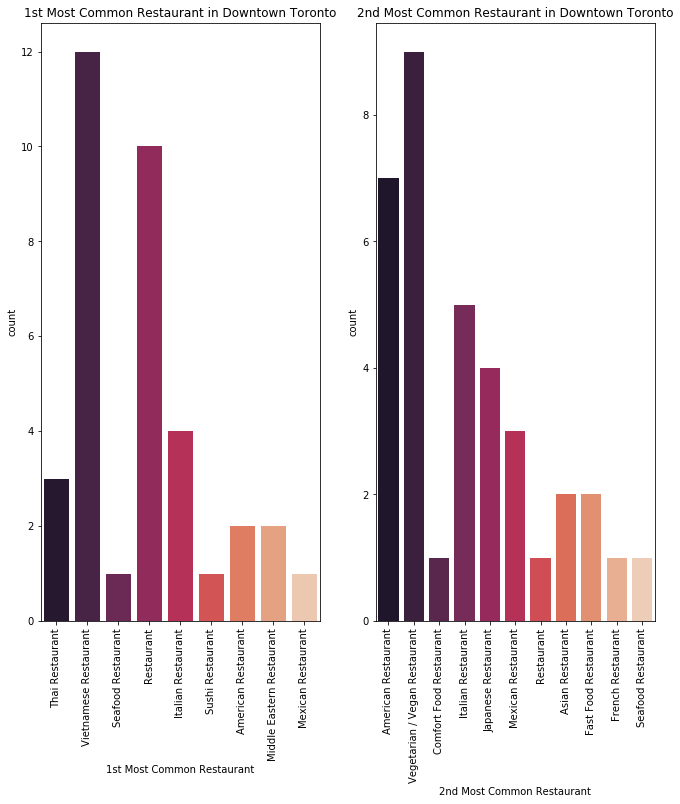

In [68]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 11))
ax1 = sns.countplot(x = '1st Most Common Restaurant', data = down_restaurants_sorted, 
                    palette = 'rocket', ax = ax1)
ax1.set_title('1st Most Common Restaurant in Downtown Toronto')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
ax2 = sns.countplot(x = '2nd Most Common Restaurant', data = down_restaurants_sorted, 
                    palette = 'rocket', ax = ax2)
ax2.set_title('2nd Most Common Restaurant in Downtown Toronto')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)
plt.show()

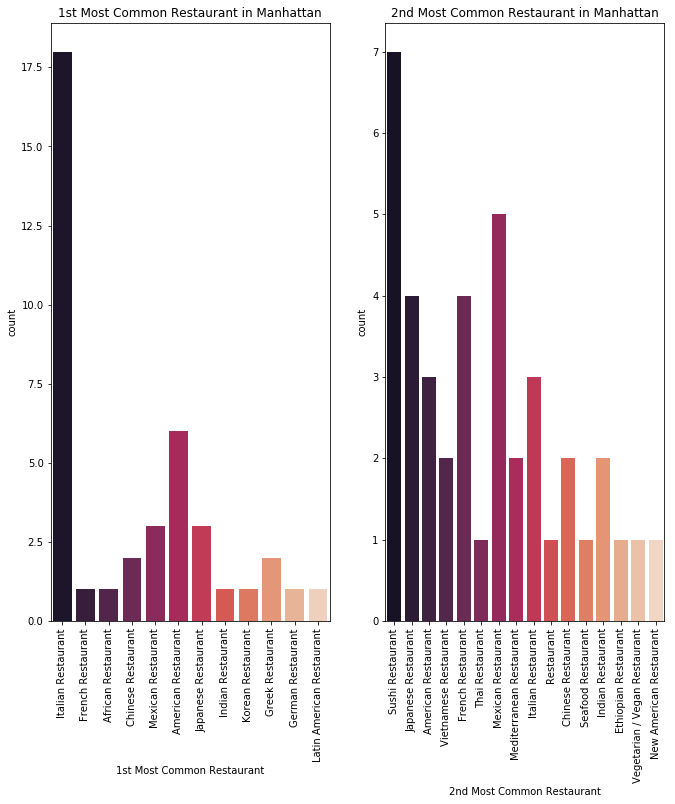

In [69]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 11))
ax1 = sns.countplot(x = '1st Most Common Restaurant', data = man_restaurants, 
                    palette = 'rocket', ax = ax1)
ax1.set_title('1st Most Common Restaurant in Manhattan')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
ax2 = sns.countplot(x = '2nd Most Common Restaurant', data = man_restaurants, 
                    palette = 'rocket', ax = ax2)
ax2.set_title('2nd Most Common Restaurant in Manhattan')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)
plt.show()

Graphs shown above are the comparison of Toronto Downtown and Manhattan